In [1]:
import os
import cv2
import numpy as np
import random
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print('Compute dtype: %s' % mixed_precision.global_policy())

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6
Compute dtype: <Policy "mixed_float16">


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 1
DATA_DIR = "C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/*/*"
NUM_TRAIN_IMAGES = 50000
NUM_VAL_IMAGES = 50
EDGE_THRESH = 10


images_path = glob(DATA_DIR)
images_path = [p.replace("\\", "/") for p in images_path]
random.shuffle(images_path)


val_images = images_path[:NUM_VAL_IMAGES]
train_images = images_path[NUM_VAL_IMAGES : NUM_TRAIN_IMAGES]


# substittui caminho de input por caminho de labels. O nome permanece
val_masks = [p.replace("input_FOV38/black", "edge_labels_FOV38") for p in val_images]
train_masks = [p.replace("input_FOV38/black", "edge_labels_FOV38") for p in train_images]
val_masks = [p.replace("input_FOV38/paredeSolid5", "edge_labels_FOV38") for p in val_masks]
train_masks = [p.replace("input_FOV38/paredeSolid5", "edge_labels_FOV38") for p in train_masks]
val_masks = [p.replace("input_FOV38/paredeSolid8", "edge_labels_FOV38") for p in val_masks]
train_masks = [p.replace("input_FOV38/paredeSolid8", "edge_labels_FOV38") for p in train_masks]
val_masks = [p.replace("input_FOV38/real", "edge_labels_FOV38") for p in val_masks]
train_masks = [p.replace("input_FOV38/real", "edge_labels_FOV38") for p in train_masks]
val_masks = [p.replace("input_FOV38/floor8wallCommom", "edge_labels_FOV38") for p in val_masks]
train_masks = [p.replace("input_FOV38/floor8wallCommom", "edge_labels_FOV38") for p in train_masks]
val_masks = [p.replace("input_FOV38/commomClean", "edge_labels_FOV38") for p in val_masks]
train_masks = [p.replace("input_FOV38/commomClean", "edge_labels_FOV38") for p in train_masks]
val_masks = [p.replace("input_FOV38/wallSolid7", "edge_labels_FOV38") for p in val_masks]
train_masks = [p.replace("input_FOV38/wallSolid7", "edge_labels_FOV38") for p in train_masks]


In [3]:

def read_image(image_path, mask=False):        
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image = tf.where(tf.image.adjust_contrast(image, 2) > EDGE_THRESH, 1, 0)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])                
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


# noise for augmentation and rondom weight for that noise
noise = tf.random.normal((5, IMAGE_SIZE, IMAGE_SIZE, 3), stddev=0.1)

def augment_data(image, mask):
         
    # random index of noise
    noise_idx = np.random.randint(0, 5)        
    noise_weight = tf.random.uniform([1])
    
    # add noise with rand weight    
    aux_image = image + noise_weight * noise[noise_idx]
           
    # change hue
    aux_image = tf.image.random_hue(aux_image, 0.20)  
        
    # clip
    image = tf.clip_by_value(aux_image, -1, 1)        
    
    return image, mask


def data_generator(image_list, mask_list):
    dataset = (tf.data.Dataset.from_tensor_slices((image_list, mask_list))
               .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
               .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
               .shuffle(BATCH_SIZE * 10)
               .batch(BATCH_SIZE, drop_remainder=True))    
    #dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

#print(train_images[0:10])

train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)


Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 224, 224, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 224, 224, 1), dtype=tf.float32, name=None))>


In [4]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,    
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)        
    return tf.nn.relu(x)


def squeeze_and_excite_block(block_input, reduction_factor=16):
    dims = block_input.shape
    
    x = layers.GlobalAveragePooling2D()(block_input)    
    x = layers.Dense(dims[-1]//reduction_factor, activation="relu")(x)
    x = layers.Dense(dims[-1], activation="sigmoid")(x)
    
    x = layers.Multiply()([x, block_input])
    
    return x

def residual_block(block_input):
    dims = block_input.shape
    
    num_filters = dims[-1] // 4
    
    x = convolution_block(block_input, num_filters=num_filters, kernel_size=1, dilation_rate=1)
    x = convolution_block(x, num_filters=num_filters, kernel_size=3, dilation_rate=1)
    x = convolution_block(x, num_filters=dims[-1], kernel_size=1, dilation_rate=1)
    
    x = layers.Add()([x, block_input])
    
    return x


def webphy_block(block_input, num_filters=64, squeeze_reduce_factor=16):
    dims = block_input.shape
    
    out_zero_padding2d_1 = layers.ZeroPadding2D()(block_input)
    
    max_pool_out = layers.MaxPooling2D((3,3), (2,2))(out_zero_padding2d_1)
    se_block_out = squeeze_and_excite_block(max_pool_out, squeeze_reduce_factor)    
    conv_out = convolution_block(max_pool_out, num_filters=dims[-1], kernel_size=3, dilation_rate=1)
    
    add_out = layers.Add()([se_block_out, conv_out])
    
    res_out = residual_block(add_out)
    
    conv_out_1 = convolution_block(res_out, num_filters=num_filters, kernel_size=3, dilation_rate=1)
        
    return conv_out_1



def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [11]:

def WebphyEdgeModel(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    
    out_1 = layers.Conv2D(filters=8, kernel_size=3, dilation_rate=1, padding='same')(model_input)        
    out_2 = layers.Conv2D(filters=8, kernel_size=3, dilation_rate=3, padding='same')(model_input)        
    out_3 = layers.Conv2D(filters=8, kernel_size=3, dilation_rate=5, padding='same')(model_input)        
    out_4 = layers.Conv2D(filters=8, kernel_size=3, dilation_rate=9, padding='same')(model_input)            
    
    out_concatenate_1 = layers.Concatenate(axis=-1)([out_1, out_2, out_3, out_4])    
    out_concatenate_1 = layers.BatchNormalization()(out_concatenate_1)   
    out_concatenate_1 = layers.ReLU()(out_concatenate_1)   
        
    # reduce
    out_9 = webphy_block(out_concatenate_1, num_filters=64)    
    out_10 = webphy_block(out_9, num_filters=128)
    
    # expand
    out_11 = layers.UpSampling2D((2,2)) (out_10)
    out_12 = convolution_block(out_11, 64)    
    out_add_1 = layers.Add()([out_9, out_12])
    x = convolution_block(out_add_1, 128)    
        
    out_13 = layers.UpSampling2D((2,2)) (x)
    out_14 = convolution_block(out_13, 32)    
    out_add_2 = layers.Add()([out_concatenate_1, out_14])    
    
    x = convolution_block(out_add_2, 64)                
        
    x = layers.Conv2D(num_classes, (1,1), padding='same')(x)                    
    
    model_output = tf.nn.sigmoid(x)
    
    return keras.Model(inputs=model_input, outputs=model_output)



model = WebphyEdgeModel(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
#model.summary()

tf.keras.models.save_model(model, "custom.h5")
print("Model created")


Model created


In [5]:
def DeeplabV3Small(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    mobileNetV3Small = keras.applications.MobileNetV3Small(alpha=1.1, include_top=False, weights=None, input_tensor=model_input, include_preprocessing=False)    
    
    x = mobileNetV3Small.get_layer("multiply_1").output
    x = DilatedSpatialPyramidPooling(x)   
    
    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear", name="Upsampling2D-1",
    )(x)
    input_b = mobileNetV3Small.get_layer("re_lu_3").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    
    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear", name="Upsampling2D-2",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", name="output_layer")(x)
    model_output = tf.nn.sigmoid(model_output)
    return keras.Model(inputs=model_input, outputs=model_output)



#model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model = DeeplabV3Small(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                                                             

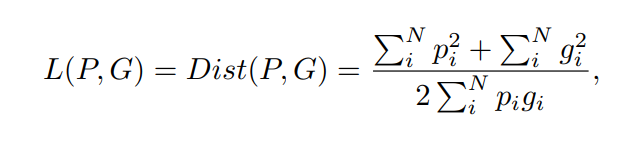
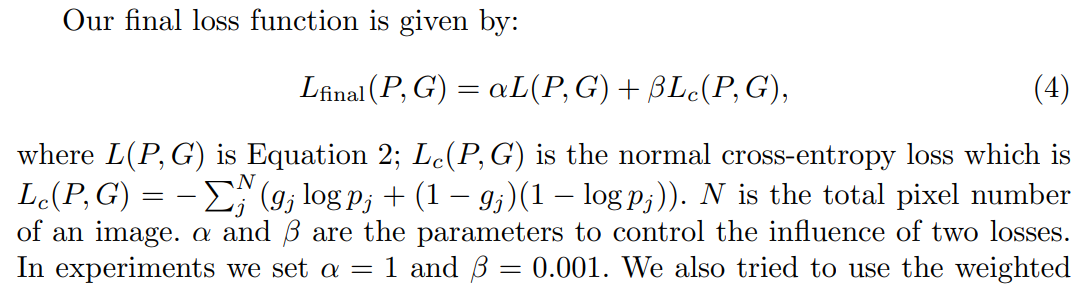

Epoch 1/10
2966/2966 [==============================] - 342s 115ms/step - loss: 2.3206 - accuracy: 0.7710 - val_loss: 2.5622 - val_accuracy: 0.7681
Epoch 2/10
2966/2966 [==============================] - 339s 114ms/step - loss: 2.2934 - accuracy: 0.7710 - val_loss: 2.6751 - val_accuracy: 0.7613
Epoch 3/10
2966/2966 [==============================] - 338s 114ms/step - loss: 2.3255 - accuracy: 0.7710 - val_loss: 2.4180 - val_accuracy: 0.7714
Epoch 4/10
2966/2966 [==============================] - 337s 114ms/step - loss: 2.3238 - accuracy: 0.7711 - val_loss: 2.4974 - val_accuracy: 0.7659
Epoch 5/10
2966/2966 [==============================] - 337s 114ms/step - loss: 2.3099 - accuracy: 0.7710 - val_loss: 2.5049 - val_accuracy: 0.7634
Epoch 6/10
2966/2966 [==============================] - 338s 114ms/step - loss: 2.2988 - accuracy: 0.7711 - val_loss: 2.5212 - val_accuracy: 0.7712
Epoch 7/10
2966/2966 [==============================] - 338s 114ms/step - loss: 2.3140 - accuracy: 0.7711 - val_

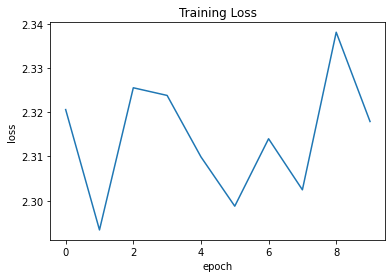

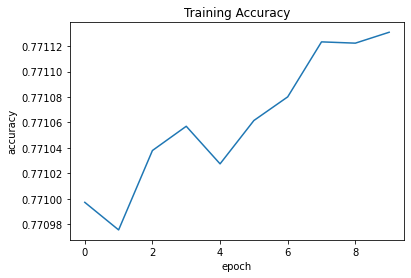

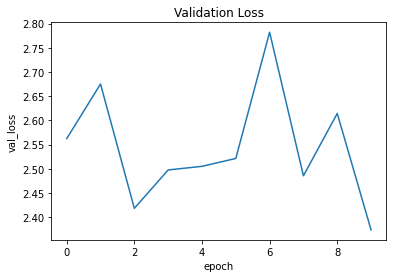

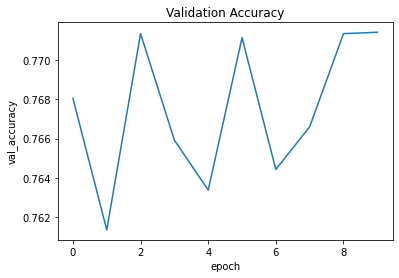

In [15]:
def loss_edge_detection(y_true, y_pred):
    loss = 0
    
    # inverter para casos em que não há borda o valor predominante ser 1 e evitar erro por divisão por 0
    y_true = keras.layers.Flatten()(y_true)
    y_pred = keras.layers.Flatten()(y_pred)        
        
    dist = tf.reduce_sum(tf.square(y_true), -1, keepdims=True) + tf.reduce_sum(tf.square(y_pred), -1, keepdims=True)        
    dist = tf.math.divide_no_nan(dist, (2*tf.reduce_sum(tf.multiply(y_pred, y_true), -1, keepdims=True)))    
        
    cross_entropy = keras.losses.binary_crossentropy(y_true, y_pred)
    
    loss = dist + 0.001*cross_entropy    
    return loss


#tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logdir', histogram_freq=1, write_images=True, profile_batch=(1, 100))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss_edge_detection,
    metrics=["accuracy"]
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10) #, callbacks=[tb_callback])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


In [16]:
# Loading the Colormap
colormap = loadmat(
    "human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)
colormap = np.roll(colormap, 1, -2)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))    
    predictions = np.squeeze(predictions)    
    #predictions = np.argmax(predictions[0], axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), norm=None, vmin=0, vmax=255)
        else:
            axes[i].imshow(display_list[i], norm=None, vmin=0, vmax=255)
    plt.show()


def plot_predictions(images_list, mask_list, colormap, model):
    for idx, image_file in enumerate(images_list):        
        print(mask_list[idx])
        print(image_file)
        image_tensor, mask_tensor = load_data(image_file, mask_list[idx])
        prediction_mask = infer(image_tensor=image_tensor, model=model)                 
        
        # binarize predictions
        prediction_mask = tf.where(prediction_mask > 0.5, 1, 0)
        
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        label_colormap = decode_segmentation_masks(mask_tensor[..., 0], colormap, NUM_CLASSES)
        
        overlay_prediction = get_overlay(image_tensor, prediction_colormap)
        overlay_label = get_overlay(image_tensor, label_colormap)        
                        
        plot_samples_matplotlib(
            [image_tensor, overlay_prediction, overlay_label], figsize=(18, 14)
        )

        

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-1-0.0000-5.4978-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-1-0.0000-5.4978-0.0000.png


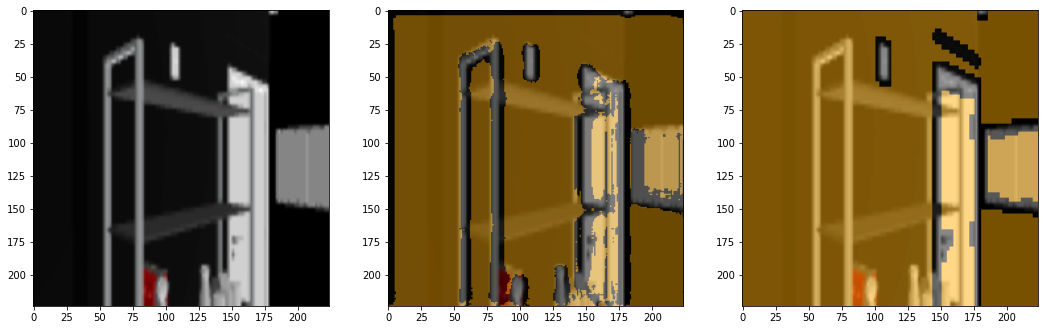

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-25-0.0000-1.0472-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-25-0.0000-1.0472-0.0000.png


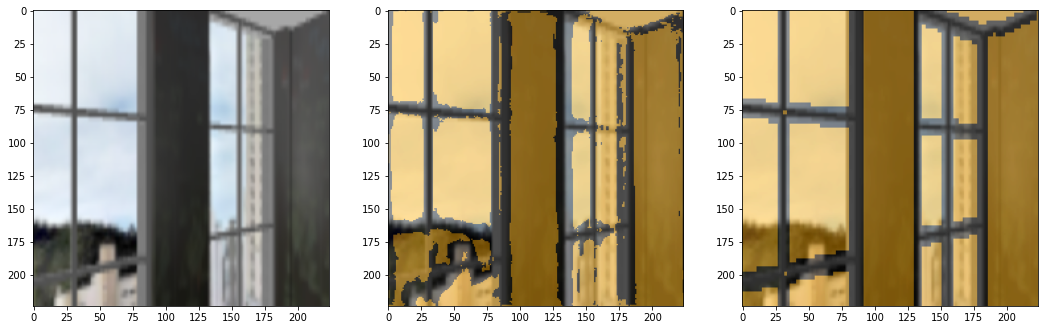

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-39-0.0000-3.6652--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-39-0.0000-3.6652--0.1222.png


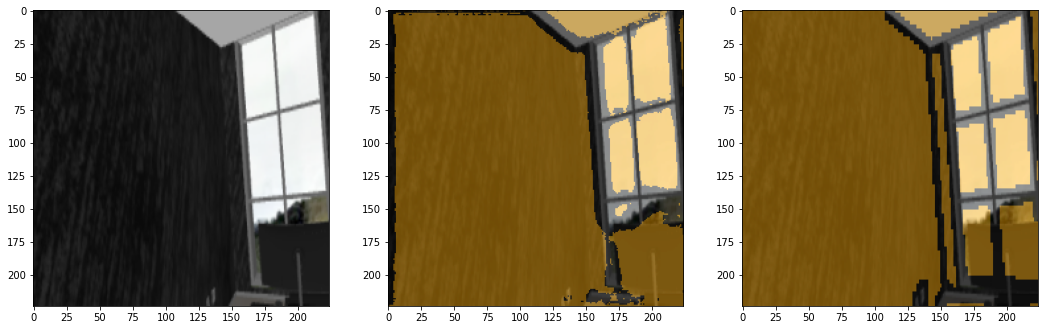

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-6-0.1222-1.0472-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-6-0.1222-1.0472-0.0000.png


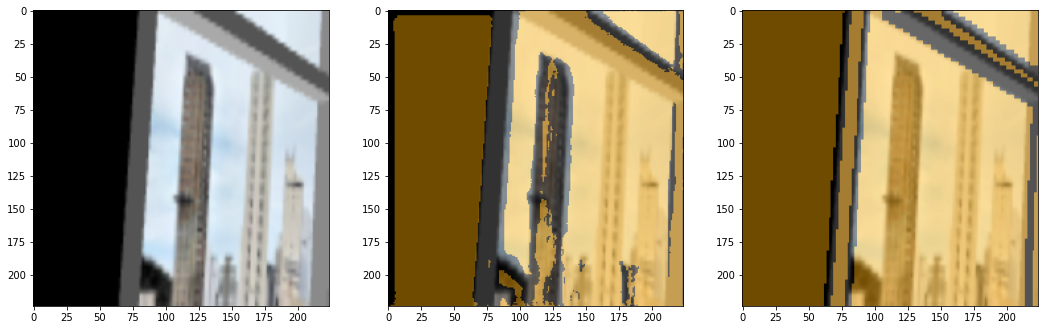

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-13-0.0000-2.3562--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-13-0.0000-2.3562--0.1222.png


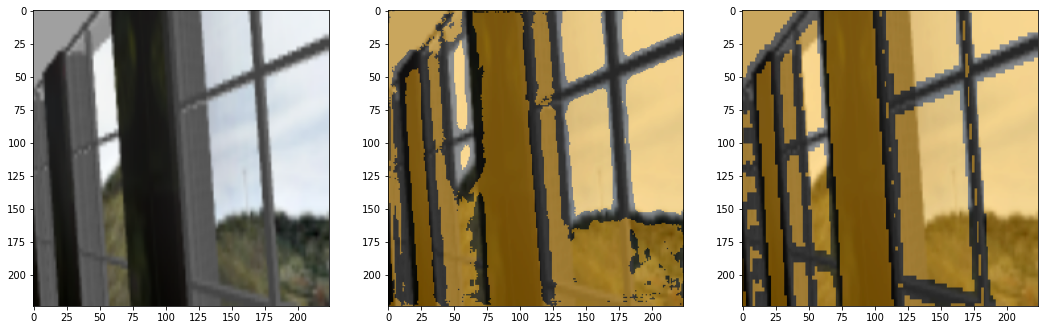

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-40-0.1222-5.7596-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-40-0.1222-5.7596-0.1222.png


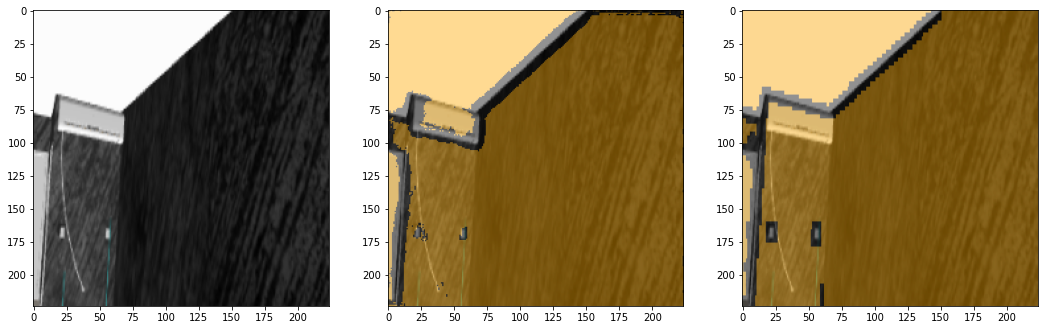

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-51-0.0000-4.9742--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-51-0.0000-4.9742--0.1222.png


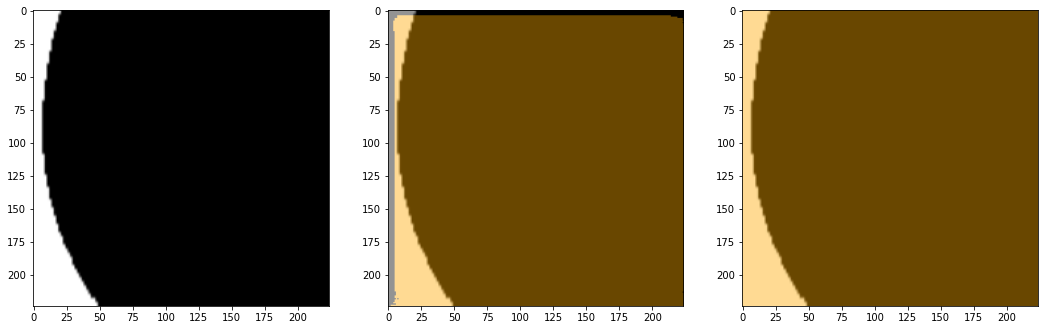

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-28--0.1222-2.0944-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-28--0.1222-2.0944-0.0000.png


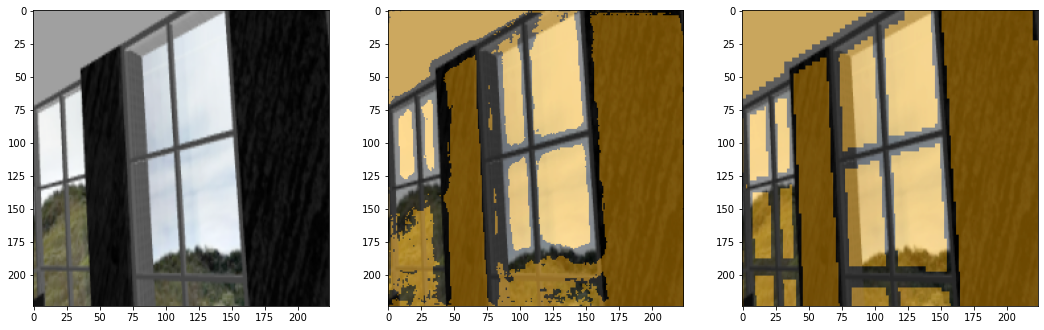

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-7--0.1222-0.7854--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-7--0.1222-0.7854--0.1222.png


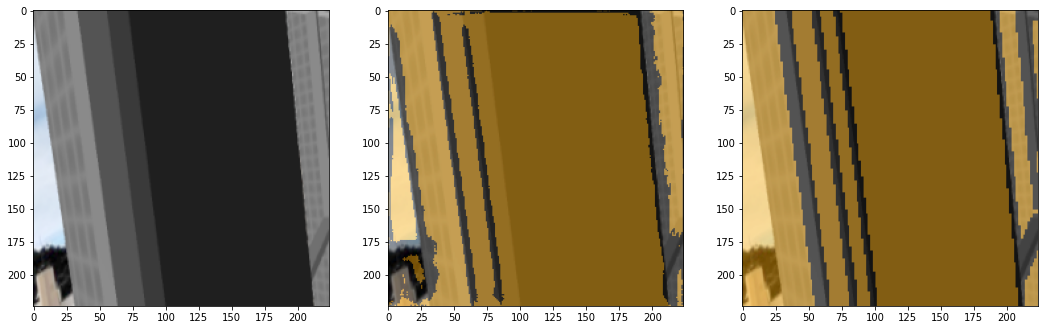

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-50--0.1222-5.4978--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-50--0.1222-5.4978--0.1222.png


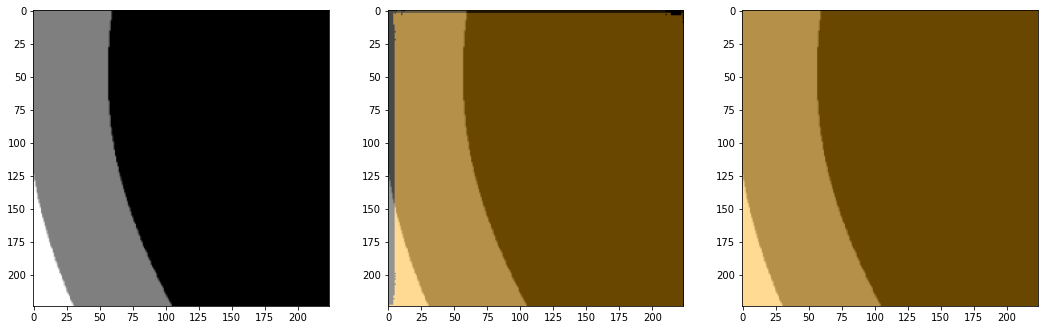

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-32-0.0000-3.4034--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-32-0.0000-3.4034--0.1222.png


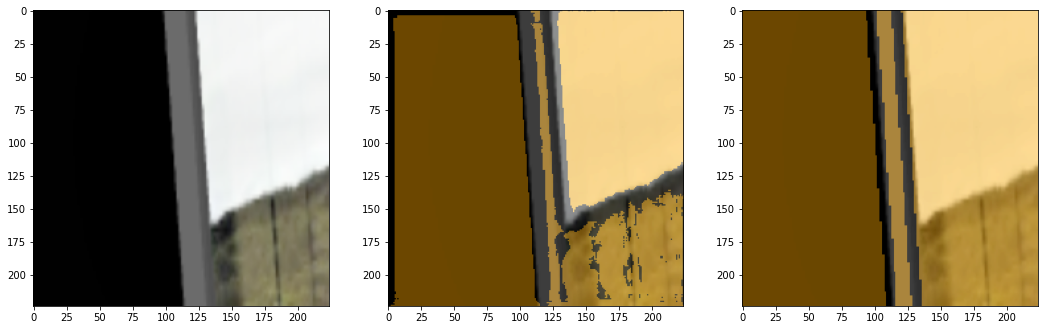

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-22--0.1222-0.0000-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-22--0.1222-0.0000-0.0000.png


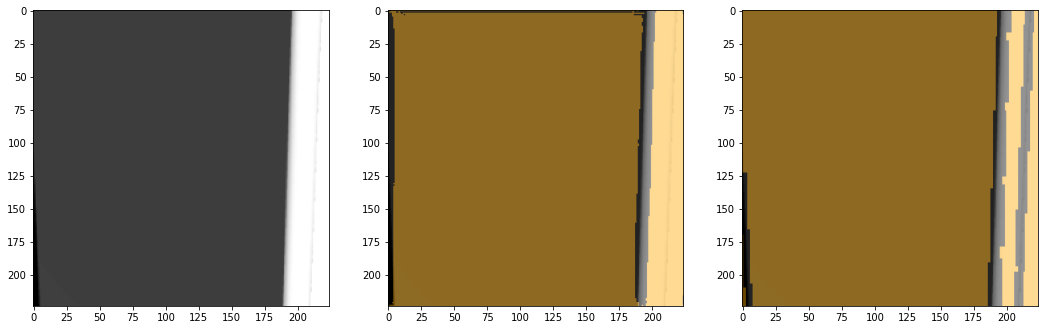

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-52--0.1222-2.8798--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-52--0.1222-2.8798--0.1222.png


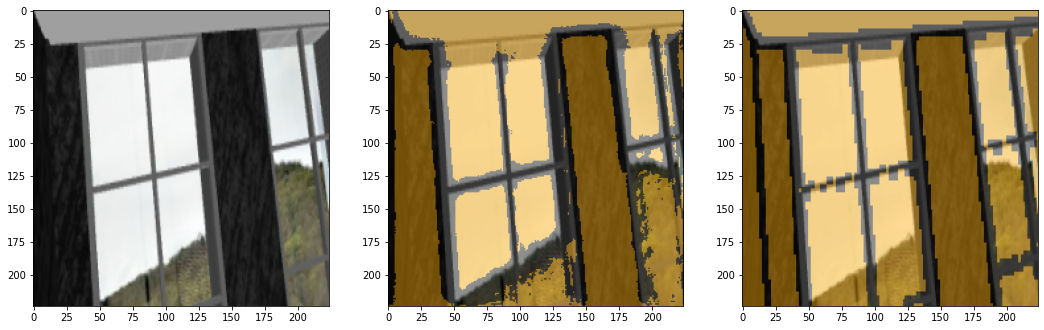

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-50-0.0000-2.3562--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-50-0.0000-2.3562--0.1222.png


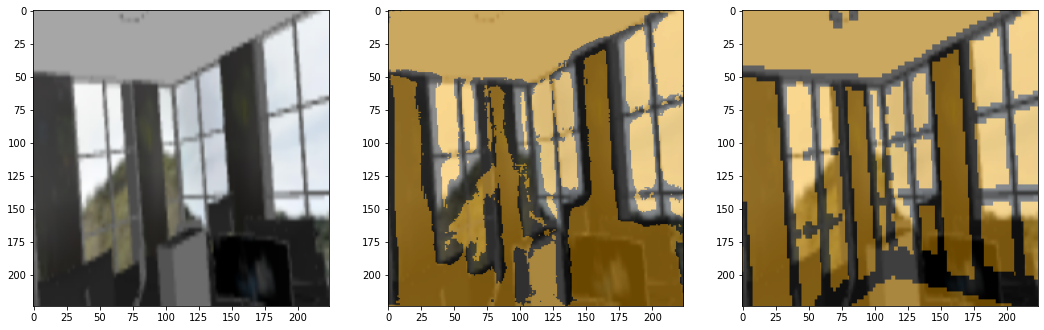

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-3-0.1222-5.2360-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-3-0.1222-5.2360-0.1222.png


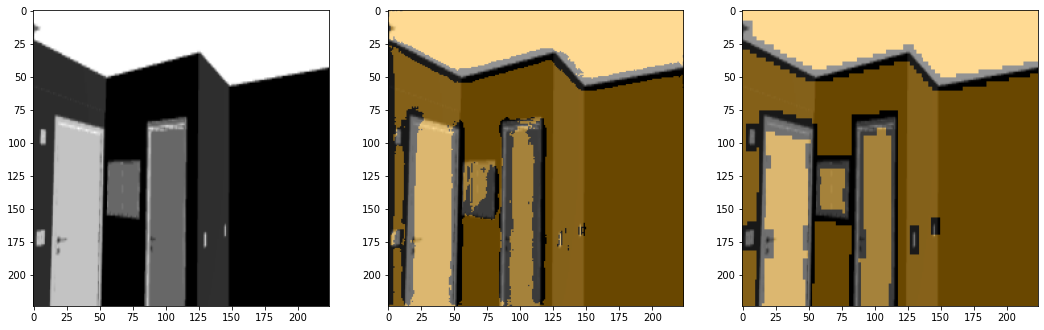

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-28--0.1222-1.8326-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-28--0.1222-1.8326-0.1222.png


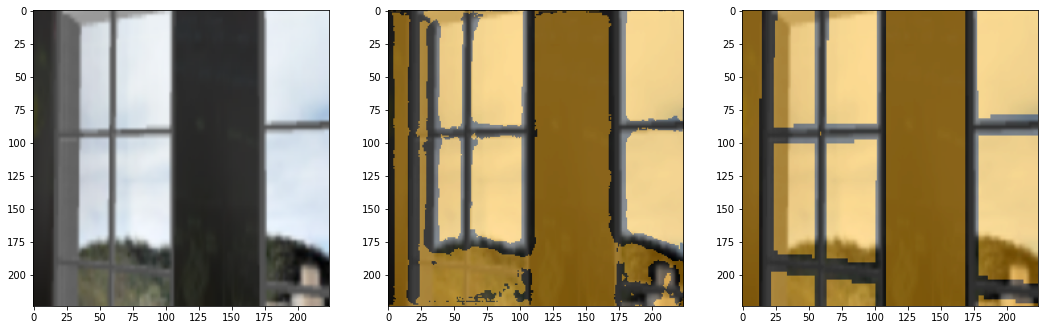

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-15-0.1222-4.4506-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-15-0.1222-4.4506-0.1222.png


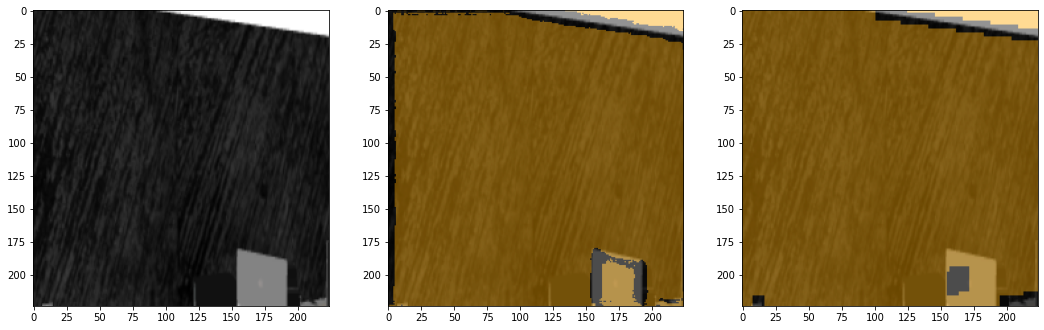

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-4-0.1222-4.4506-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-4-0.1222-4.4506-0.0000.png


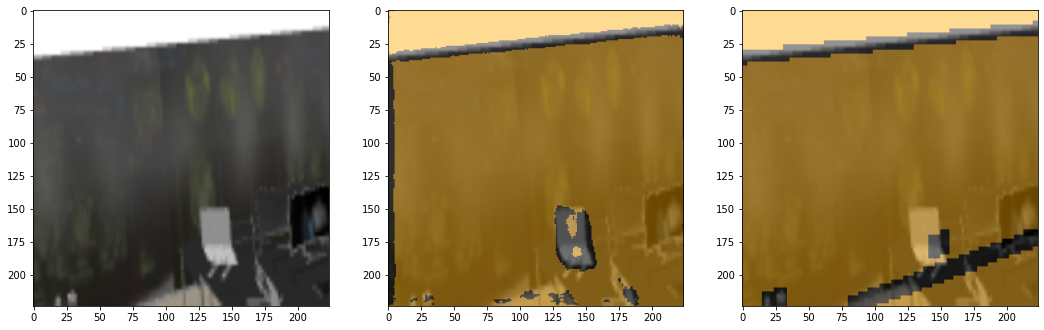

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-4--0.1222-1.0472--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-4--0.1222-1.0472--0.1222.png


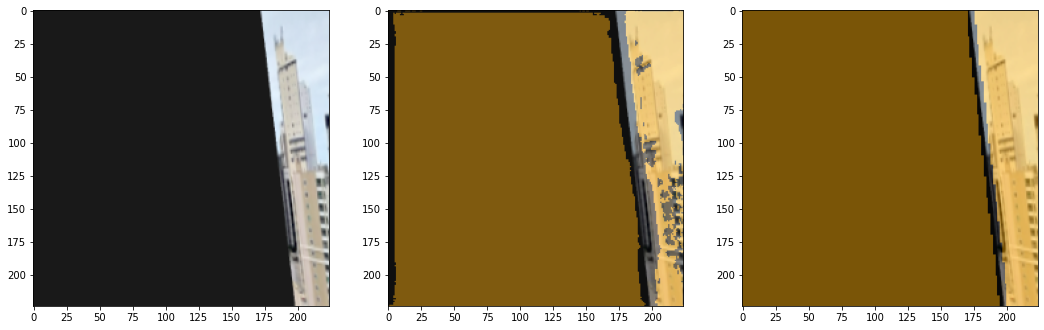

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-51--0.1222-2.6180--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-51--0.1222-2.6180--0.1222.png


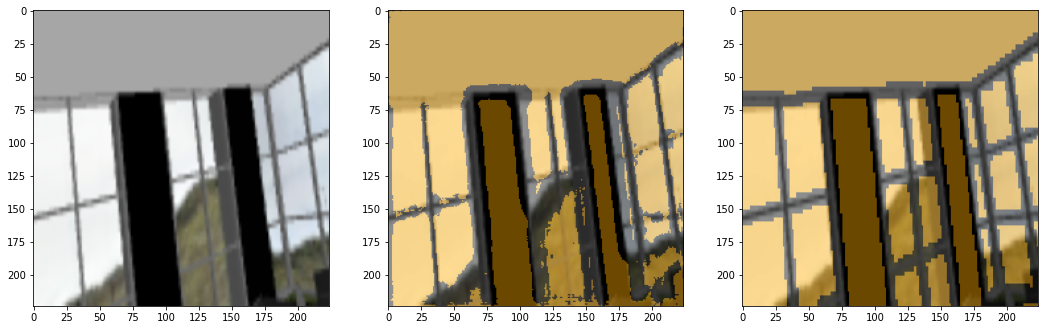

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-46--0.1222-1.3090-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-46--0.1222-1.3090-0.0000.png


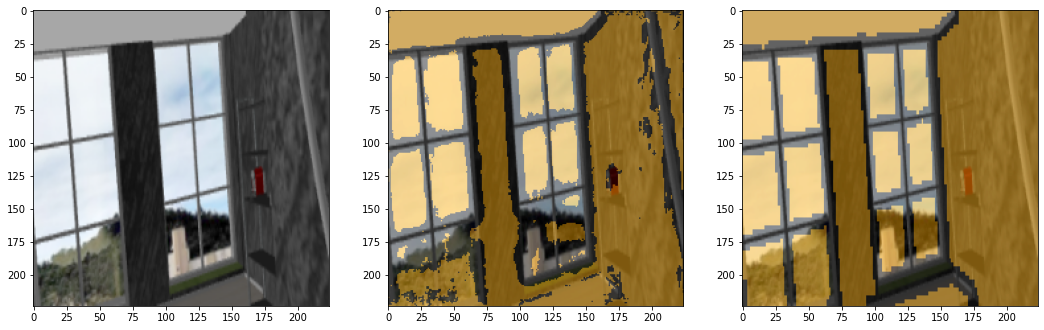

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-20-0.1222-0.0000-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-20-0.1222-0.0000-0.1222.png


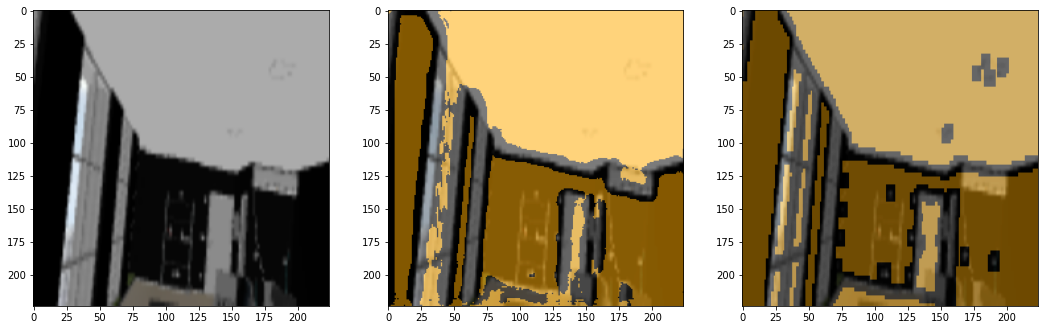

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-39--0.1222-1.0472-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-39--0.1222-1.0472-0.0000.png


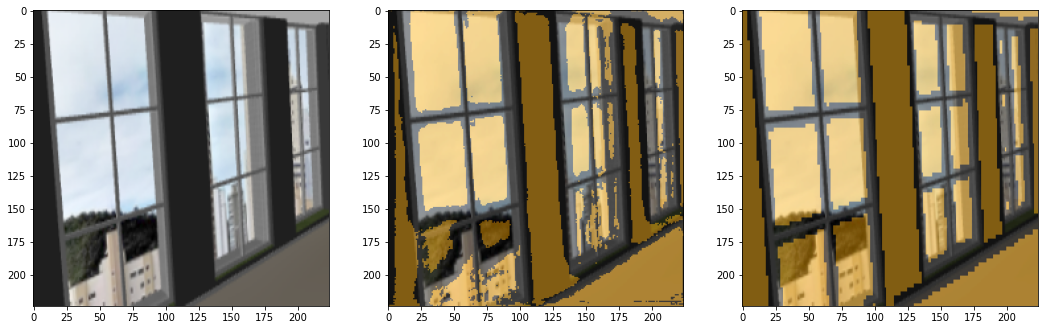

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-9--0.1222-3.1416--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-9--0.1222-3.1416--0.1222.png


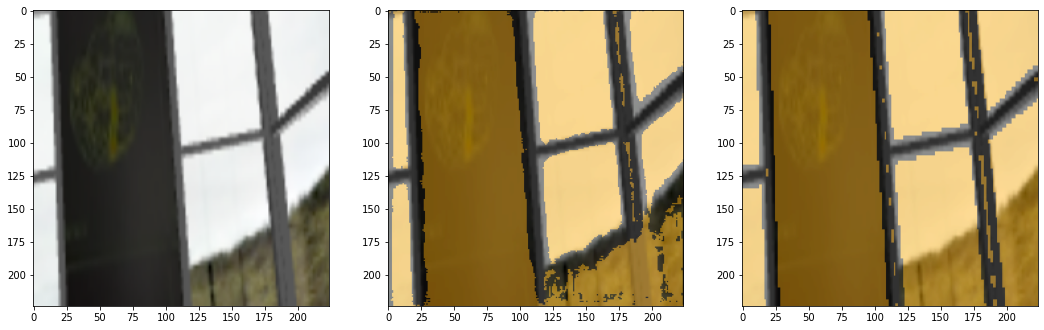

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-7-0.1222-1.8326-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-7-0.1222-1.8326-0.0000.png


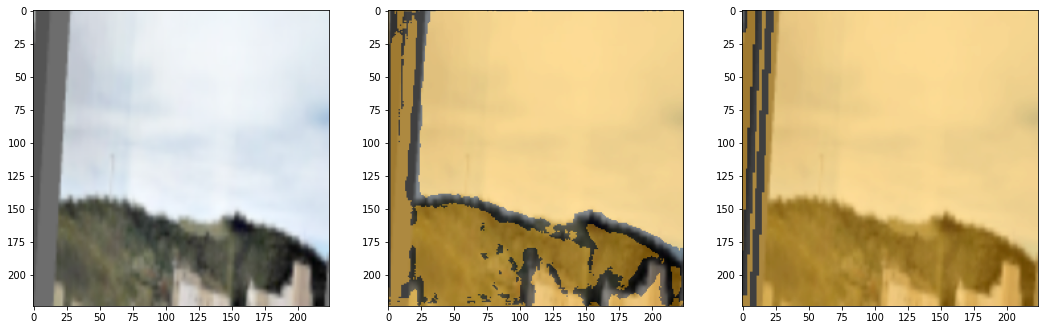

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-41--0.1222-1.3090-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-41--0.1222-1.3090-0.0000.png


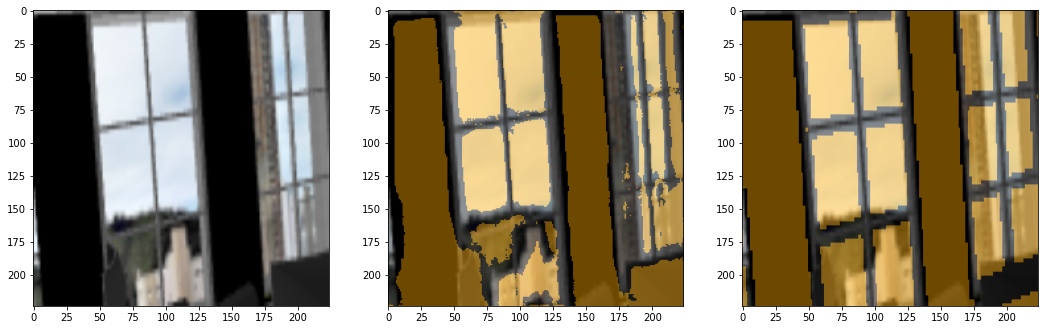

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-38-0.0000-3.6652-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-38-0.0000-3.6652-0.1222.png


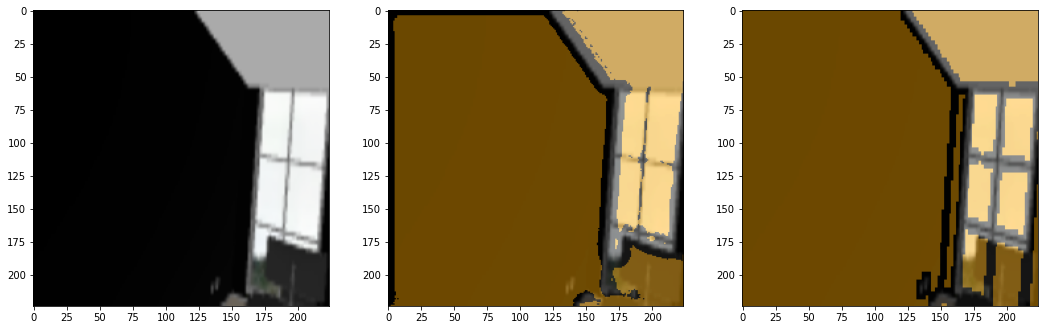

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-40--0.1222-4.1888-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-40--0.1222-4.1888-0.0000.png


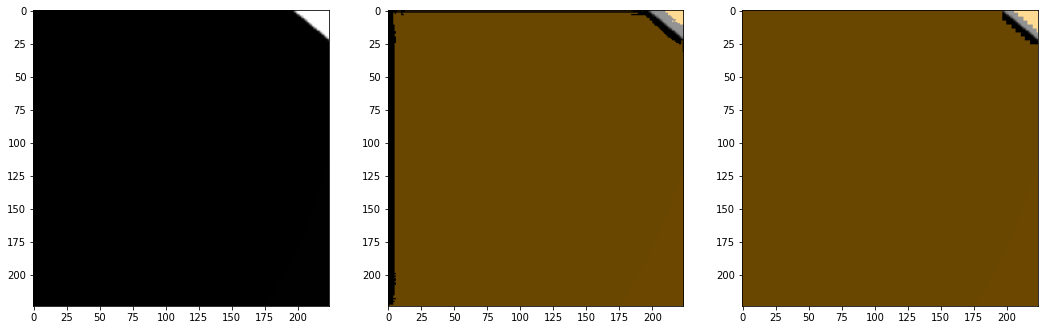

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-18-0.1222-4.4506--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-18-0.1222-4.4506--0.1222.png


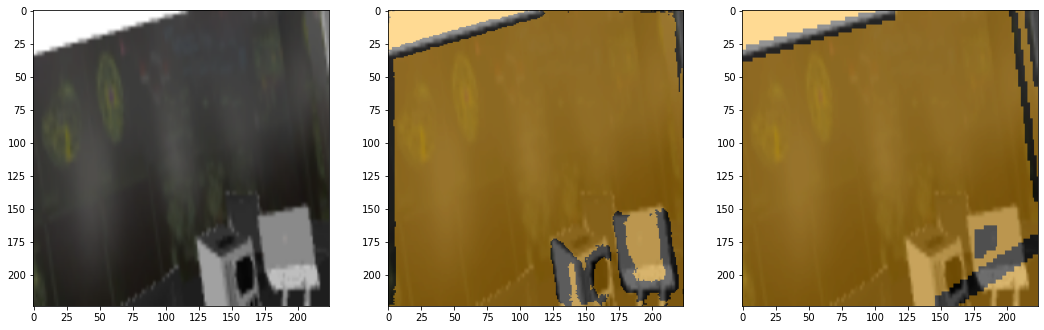

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-43-0.0000-1.0472-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-43-0.0000-1.0472-0.1222.png


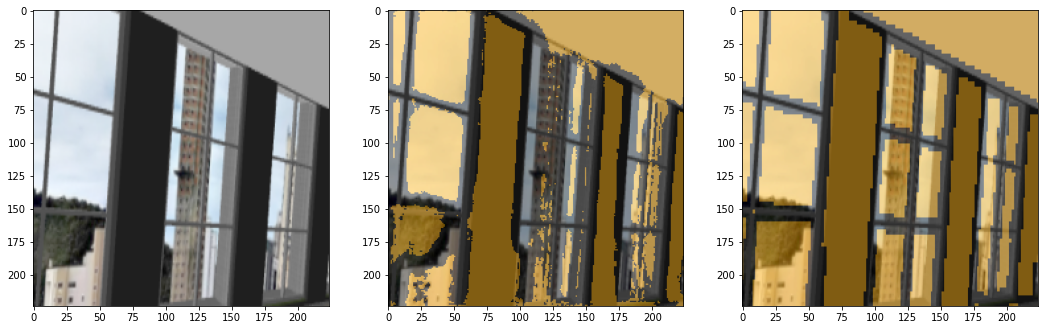

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-43-0.1222-0.5236-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-43-0.1222-0.5236-0.1222.png


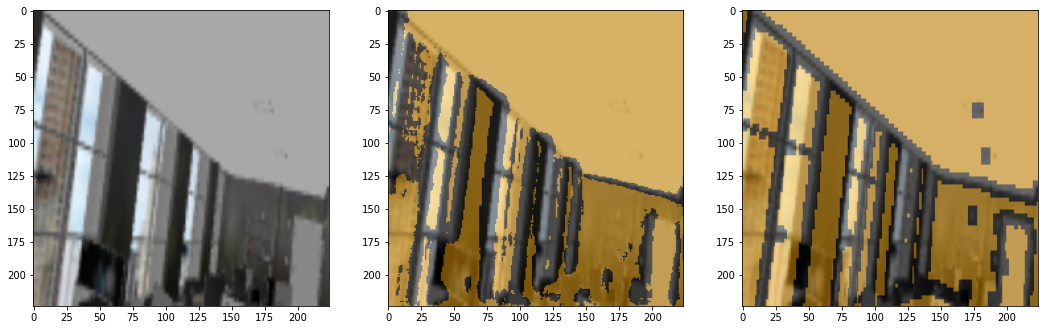

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-29--0.1222-2.3562-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-29--0.1222-2.3562-0.1222.png


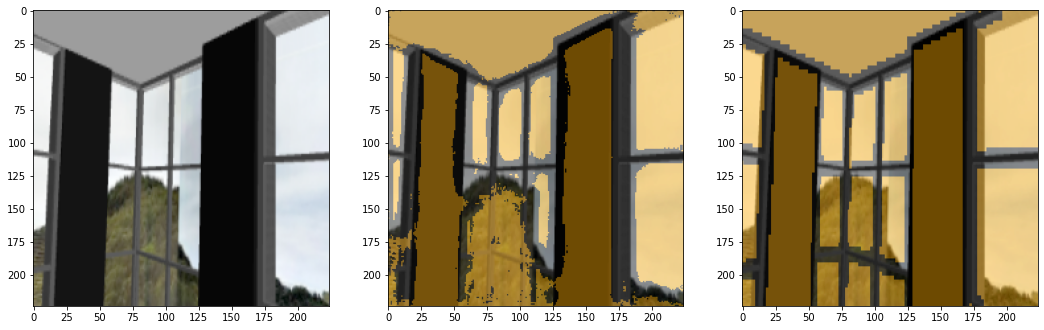

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-25-0.0000-4.1888-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-25-0.0000-4.1888-0.1222.png


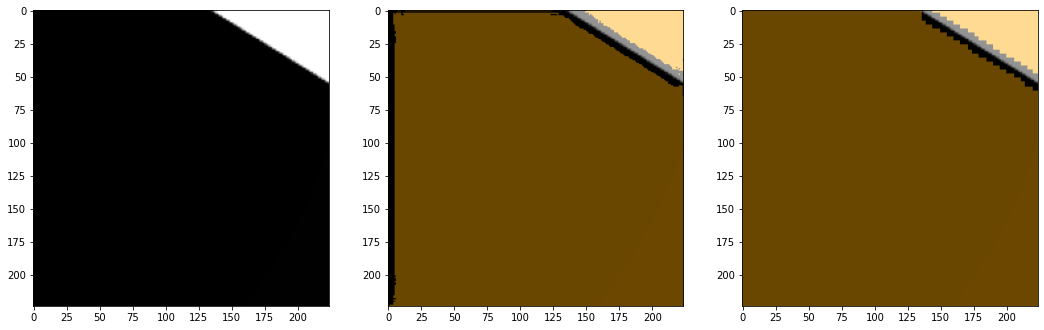

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-44--0.1222-5.7596-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-44--0.1222-5.7596-0.1222.png


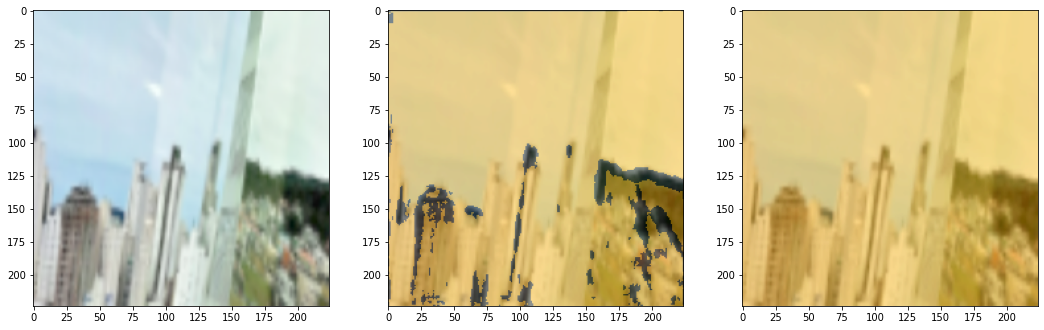

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-39-0.0000-4.9742-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-39-0.0000-4.9742-0.1222.png


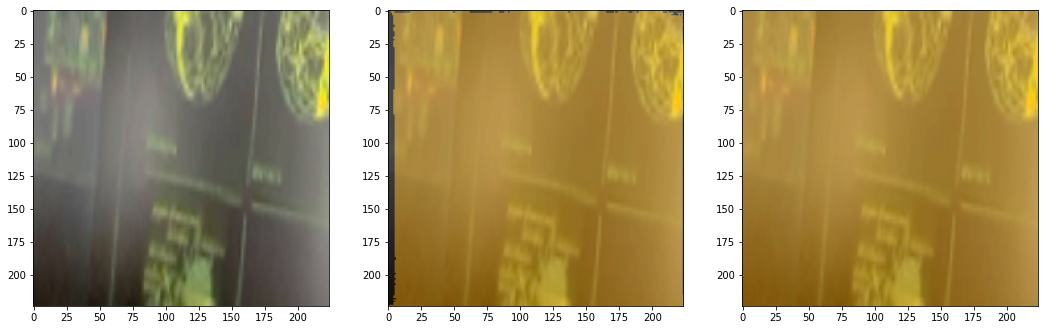

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-22--0.1222-3.6652--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-22--0.1222-3.6652--0.1222.png


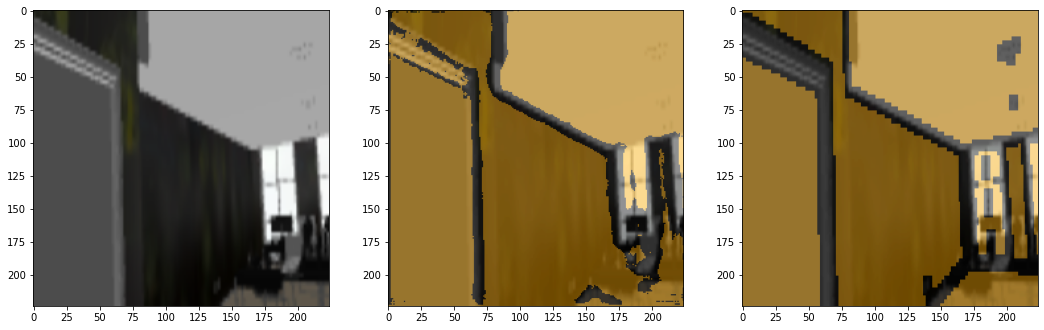

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-35-0.1222-4.9742-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-35-0.1222-4.9742-0.0000.png


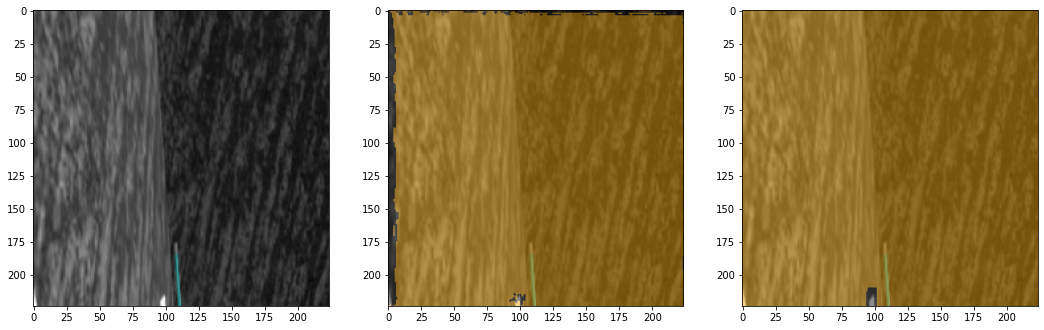

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-14-0.1222-2.8798-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-14-0.1222-2.8798-0.1222.png


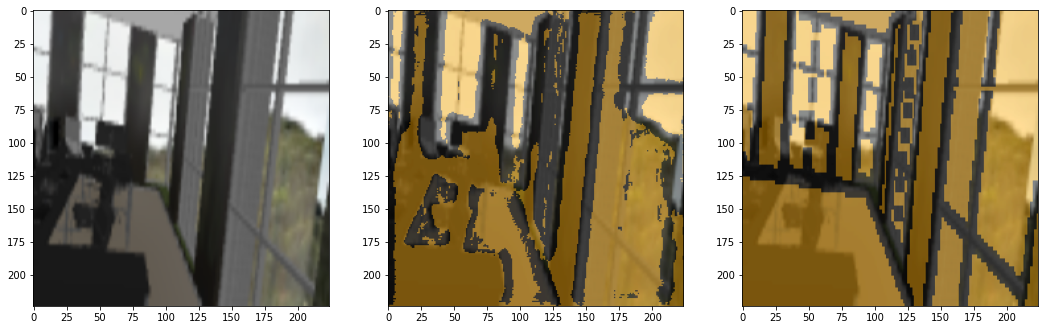

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-42-0.1222-1.0472-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-42-0.1222-1.0472-0.0000.png


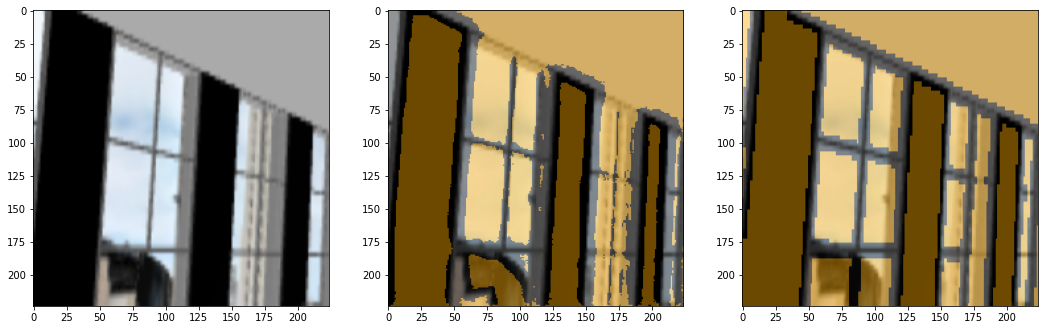

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-44-0.1222-4.7124-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-44-0.1222-4.7124-0.0000.png


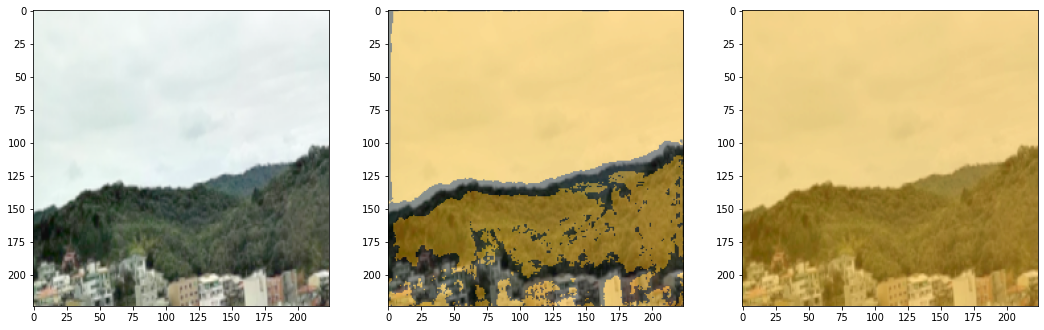

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-2--0.1222-3.4034-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-2--0.1222-3.4034-0.0000.png


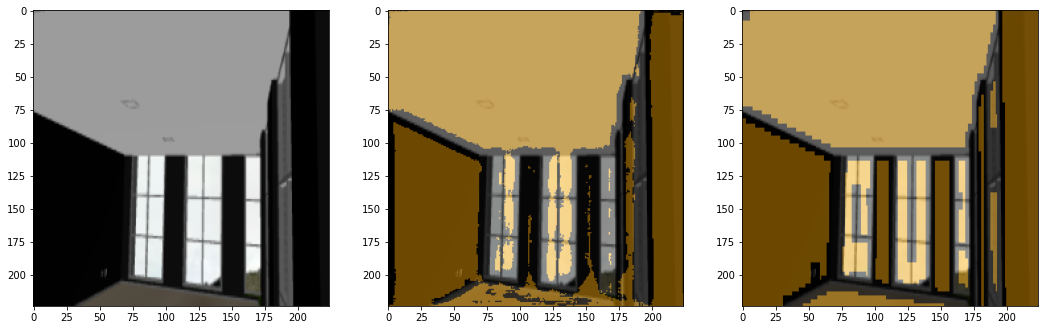

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-12-0.1222-4.4506-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-12-0.1222-4.4506-0.0000.png


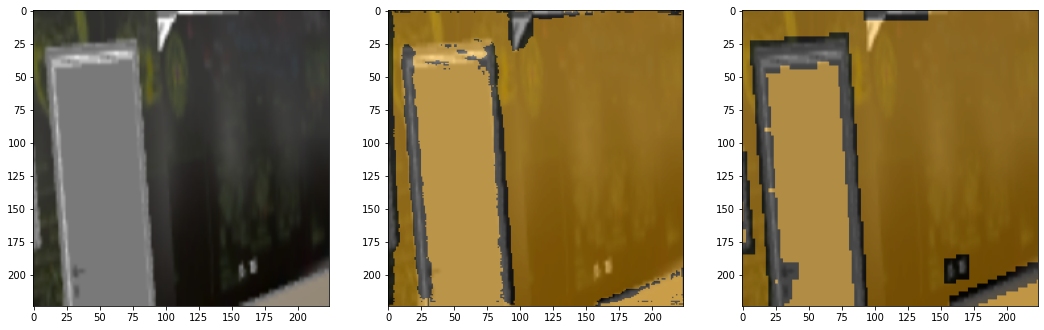

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-0-0.1222-4.4506--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-0-0.1222-4.4506--0.1222.png


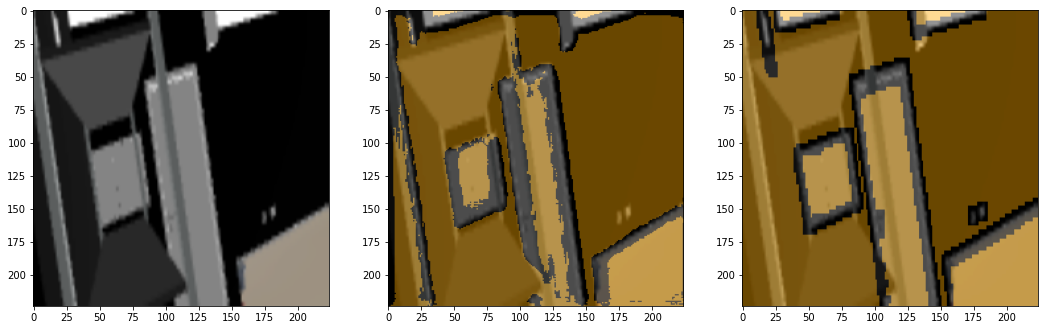

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-33-0.1222-0.5236-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-33-0.1222-0.5236-0.0000.png


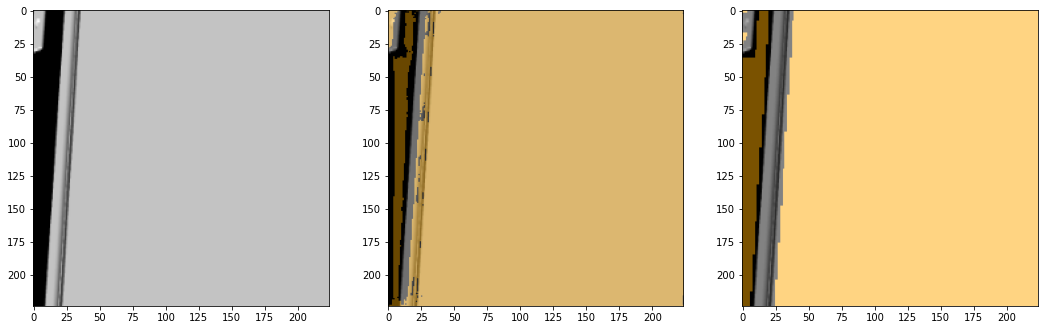

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-14--0.1222-0.2618-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-14--0.1222-0.2618-0.0000.png


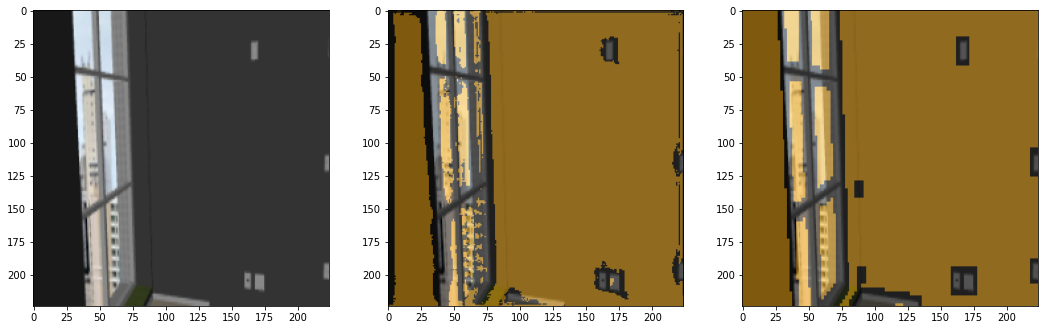

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-17--0.1222-5.2360--0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/wallSolid7/common-17--0.1222-5.2360--0.1222.png


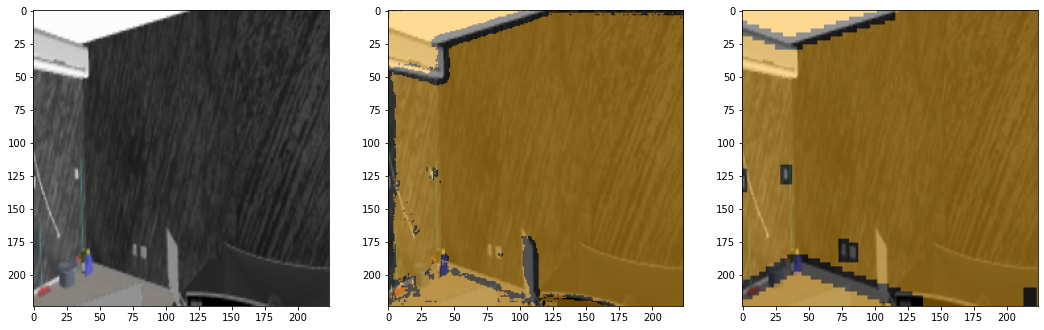

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-50-0.0000-1.0472-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/black/common-50-0.0000-1.0472-0.0000.png


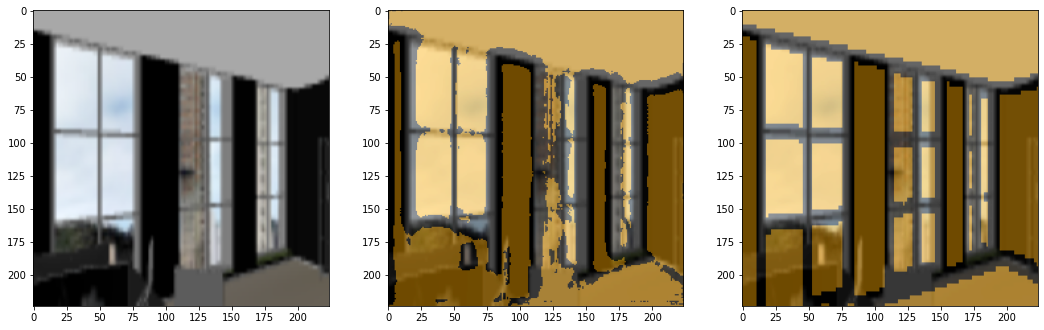

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-24--0.1222-2.6180-0.0000.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-24--0.1222-2.6180-0.0000.png


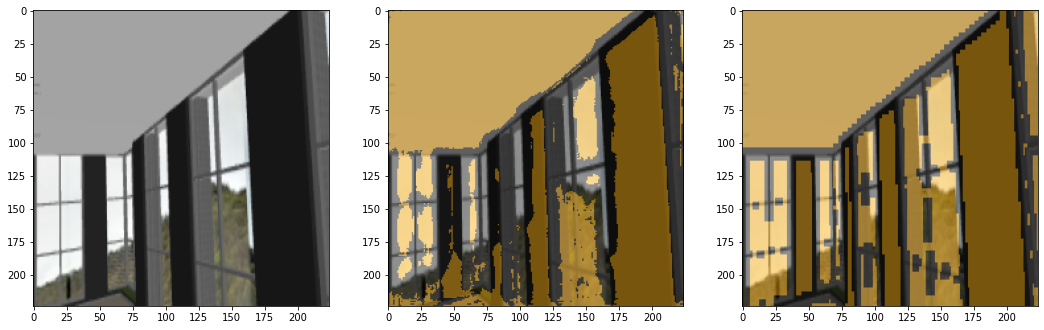

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-48--0.1222-3.6652-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/real/common-48--0.1222-3.6652-0.1222.png


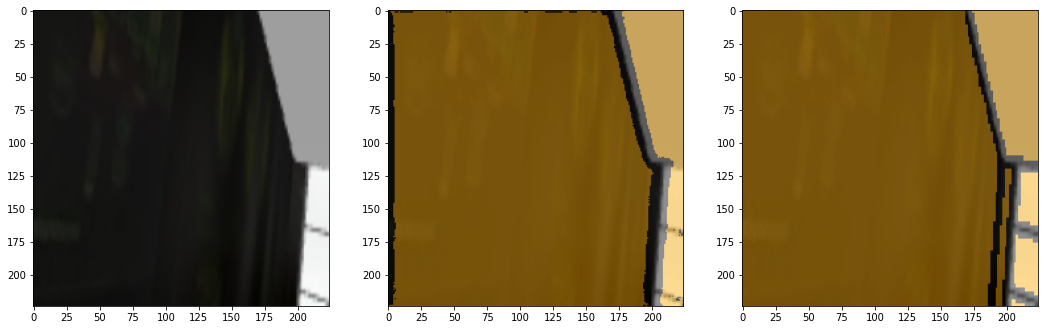

C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/edge_labels_FOV38/common-25-0.0000-3.1416-0.1222.png
C:/Users/T-GAMER/Desktop/workspace/indoor_data_generator/testeInterface/root/input_FOV38/commomClean/common-25-0.0000-3.1416-0.1222.png


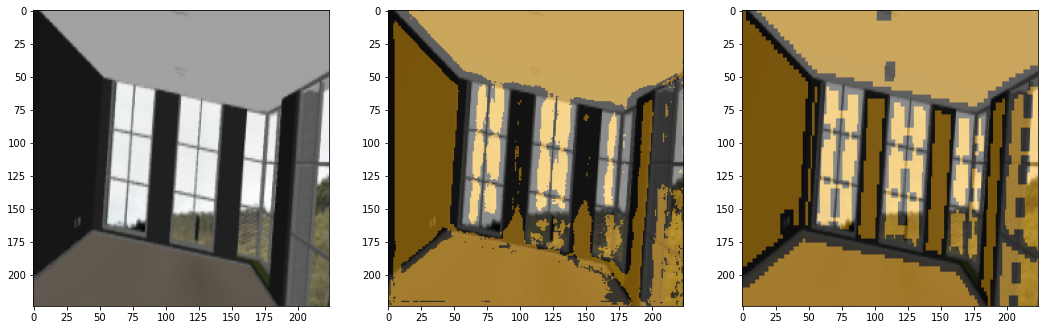

In [17]:
plot_predictions(val_images[0:50], val_masks[0:50], colormap, model=model)

In [ ]:
tf.keras.models.save_model(model, "segmodelv3.h5")

In [ ]:
for data in train_dataset.take(5).as_numpy_iterator():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))

    ax1.imshow((data[1][0]+1)/2 )
    ax2.imshow((data[1][1]+1)/2 )
    ax3.imshow((data[1][2]+1)/2 )
   
    plt.show()